In [6]:
import numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns, pandas

In [7]:
def get_xy(np_array):
  return np.where(~np.isnan(np_array))[0], np_array[~np.isnan(np_array)]

In [8]:
def get_dict_of_arrays(exp_model_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='pppl.npy',convert_for_plot=True):
    np_arrays = {}
    
    for exp, models in exp_model_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            if convert_for_plot:
                np_arrays[model] = get_xy(np.load(file_name))
            else:
                np_arrays[model] = np.load(file_name)

    return np_arrays

In [9]:
def get_dict_of_df(df_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='filtered_df.csv'):
    
    dfs = {}
    
    for exp, models in df_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            dfs[model] = pandas.read_csv(file_name)
    return dfs

In [10]:
# berts = {
#     'filter_newline' : ['bert-base-cased', 'bert-large-cased'],
#     'multilingual' : ['bert-base-multilingual-cased']
# }

# bert_dfs = get_dict_of_df(berts)
# bert_nps = get_dict_of_arrays(berts, fname_to_read='filtered_log_probs.npy', convert_for_plot=False)

# df = bert_dfs['bert-base-multilingual-cased']
# a = bert_nps['bert-base-multilingual-cased']

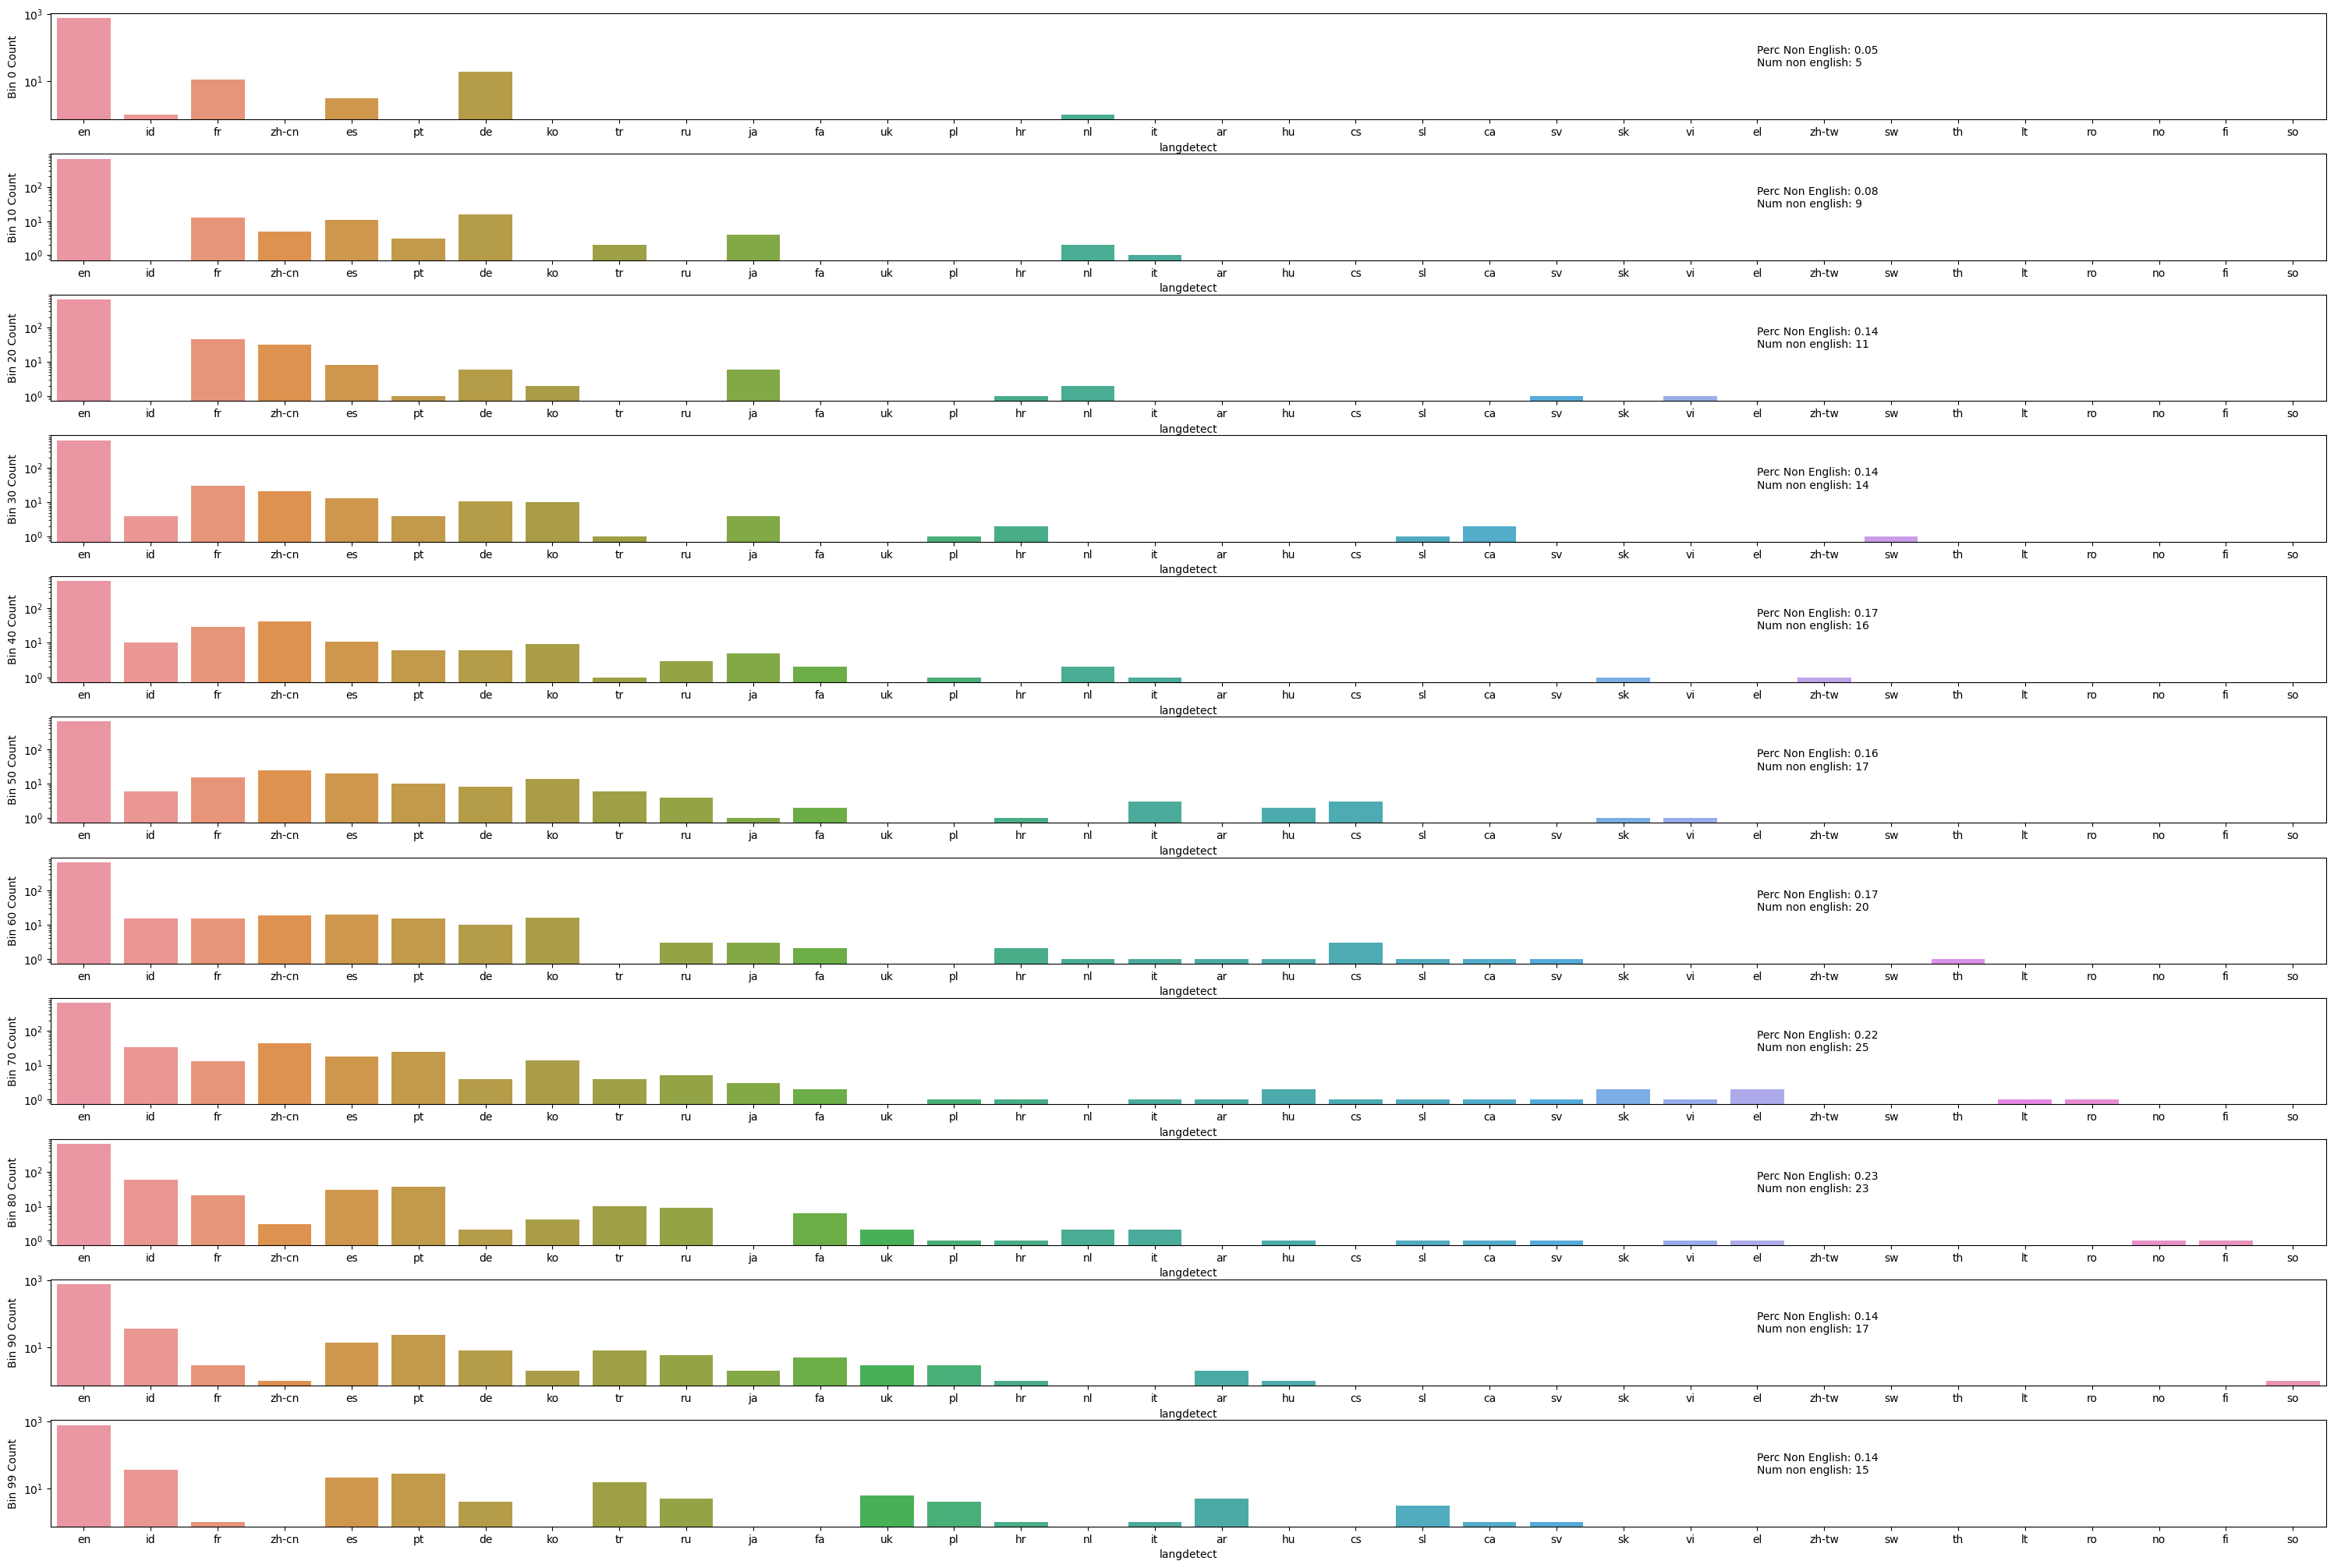

In [11]:
berts = {
    'filter_newline' : ['bert-base-cased', 'bert-large-cased'],
    'multilingual' : ['bert-base-multilingual-cased']
}

bert_dfs = get_dict_of_df(berts)
bert_nps = get_dict_of_arrays(berts, fname_to_read='filtered_log_probs.npy', convert_for_plot=False)

df = bert_dfs['bert-base-multilingual-cased']
a = bert_nps['bert-base-multilingual-cased']

bins = df['bin'].unique()

fig, ax = plt.subplots(len(bins), figsize=(30,20))
fig.tight_layout()

for i, bin in zip(range(len(bins)), bins):
    sns.countplot(df[df['bin'] == bin], x='langdetect', log=True, order=df['langdetect'].value_counts().index, ax=ax[i])
    ax[i].set_ylabel(f'Bin {bin} Count')
    perc_non_english = 1 - df[df['bin'] == bin]['langdetect'].value_counts()['en'] / df[df['bin'] == bin]['langdetect'].value_counts().sum()
    num_non_english =  df[df['bin'] == bin]['langdetect'].value_counts().shape[0] - 1
    ax[i].text(0.75,0.5, transform=ax[i].transAxes, s=f'Perc Non English: {perc_non_english:.2f}\nNum non english: {num_non_english}')
    

In [12]:
def calculate_pppl(arr): # Expects input of shape (sample_size, max_seq_len). Calcualtes over all given samples

    total_tokens = np.sum(~np.isnan(arr))
    total_sum = np.nansum(arr) * -1
    return np.exp(total_sum / total_tokens)

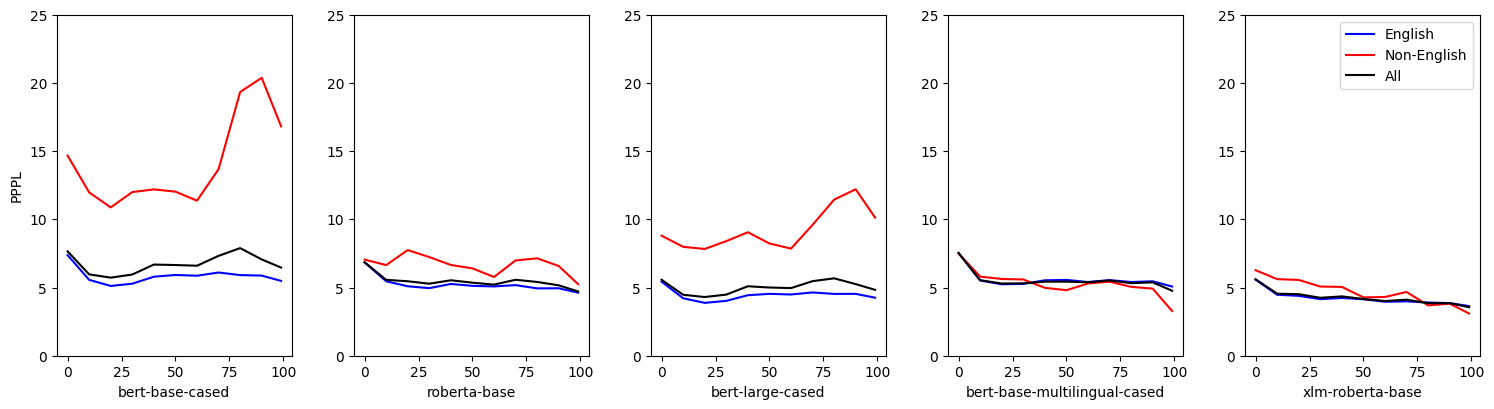

In [14]:
fig, ax = plt.subplots(1,5, figsize=(15,4))
fig.tight_layout()

colors = ['blue', 'red', 'black']

models = {
    'filter_newline' : ['bert-base-cased', 'roberta-base', 'bert-large-cased'],
    'multilingual' : ['bert-base-multilingual-cased', 'xlm-roberta-base']
}

model_dfs = get_dict_of_df(models)
model_nps = get_dict_of_arrays(models, fname_to_read='filtered_log_probs.npy', convert_for_plot=False)

for i, (k,v) in enumerate(model_dfs.items()):

    arr = model_nps[k]
    
    english_ids = v[v['langdetect'] == 'en'][['bin', 'local_id']]
    non_english_ids = v[v['langdetect'] != 'en'][['bin', 'local_id']]
    all_ids = v[['bin', 'local_id']]

    for j, (id_set, name) in enumerate(zip([english_ids, non_english_ids, all_ids], ['English', 'Non-English', 'All'])):
    
        bins = id_set['bin'].unique()
        vals = np.zeros(bins.shape)
        
        for bin_idx, bin in enumerate(bins):
            local_ids = id_set[id_set['bin'] == bin]['local_id']
            vals[bin_idx] = calculate_pppl(arr[bin, local_ids,:])

        ax[i].plot(bins, vals, label=name, color=colors[j])
        
    ax[i].set_ylim(bottom=0.0, top=25.0)
    ax[i].set_xlabel(k)
ax[0].set_ylabel('PPPL')
ax[-1].legend()